In [9]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score,train_test_split, KFold, cross_val_predict
from sklearn.metrics import mean_squared_error,r2_score,roc_curve,auc,precision_recall_curve, accuracy_score, \
recall_score, precision_score, confusion_matrix
from sklearn.metrics import accuracy_score, mean_absolute_error, mean_squared_error, r2_score, \
roc_curve, auc, precision_score, recall_score, confusion_matrix
from sklearn.tree import DecisionTreeRegressor,DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV, ParameterGrid, StratifiedKFold
from sklearn.ensemble import GradientBoostingRegressor,GradientBoostingClassifier, BaggingRegressor,BaggingClassifier,RandomForestRegressor,RandomForestClassifier,AdaBoostRegressor,AdaBoostClassifier
from sklearn.linear_model import LinearRegression,LogisticRegression
from sklearn.model_selection import GridSearchCV, ParameterGrid, StratifiedKFold, RandomizedSearchCV
from sklearn.ensemble import VotingRegressor, VotingClassifier, StackingRegressor, StackingClassifier, GradientBoostingRegressor,GradientBoostingClassifier, BaggingRegressor,BaggingClassifier,RandomForestRegressor,RandomForestClassifier,AdaBoostRegressor,AdaBoostClassifier
from sklearn.linear_model import LinearRegression,LogisticRegression, LassoCV, RidgeCV, ElasticNetCV
from sklearn.neighbors import KNeighborsRegressor
import xgboost as xgb
from sklearn.neighbors import KNeighborsRegressor
import itertools as it

import warnings
warnings.filterwarnings("ignore")

In [2]:
movies = pd.read_csv('movies_classification_updated.csv')

In [3]:
movies

,Unnamed: 0,belongs_to_collection,budget,revenue,runtime,title,Animation,Comedy,Family,Adventure,...,Mystery,War,Foreign,Music,Documentary,Western,TV Movie,english,release_year,release_month
0,0,1,30000000,1.0,81.0,Toy Story,1,1,1,0,...,0,0,0,0,0,0,0,1,1995,10.0
1,1,0,65000000,1.0,104.0,Jumanji,0,0,1,1,...,0,0,0,0,0,0,0,1,1995,12.0
2,2,1,0,0.0,101.0,Grumpier Old Men,0,1,0,0,...,0,0,0,0,0,0,0,1,1995,12.0
3,3,0,16000000,1.0,127.0,Waiting to Exhale,0,1,0,0,...,0,0,0,0,0,0,0,1,1995,12.0
4,4,1,0,1.0,106.0,Father of the Bride Part II,0,1,0,0,...,0,0,0,0,0,0,0,1,1995,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44691,45460,0,0,0.0,104.0,Robin Hood,0,0,0,0,...,0,0,0,0,0,0,0,1,1991,5.0
44692,45462,0,0,0.0,360.0,Century of Birthing,0,0,0,0,...,0,0,0,0,0,0,0,0,2011,11.0
44693,45463,0,0,0.0,90.0,Betrayal,0,0,0,0,...,0,0,0,0,0,0,0,1,2003,8.0
44694,45464,0,0,0.0,87.0,Satan Triumphant,0,0,0,0,...,0,0,0,0,0,0,0,1,1917,10.0


In [29]:
#Preparing the data
y = movies['revenue']
X = movies.drop(["revenue", "title","Unnamed: 0"],axis = 1)
X.dropna(how = 'all', inplace = True)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 45)

In [ ]:
#Tuning the hyperparameters of the AdaBoost model with a coarse search
model = AdaBoostRegressor(random_state=1)
grid = dict()
grid['n_estimators'] = [10, 50, 100, 200]
grid['learning_rate'] = [0.0001, 0.001, 0.01,0.1, 1.0]
grid['base_estimator'] = [DecisionTreeClassifier(max_depth=3), DecisionTreeClassifier(max_depth=5), 
                          DecisionTreeClassifier(max_depth=10)]

# define the evaluation procedure
cv = KFold(n_splits=5, shuffle=True, random_state=1)

# define the grid search procedure
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='precision')

# execute the grid search
grid_result = grid_search.fit(X_train, y_train)

# summarize the best score and configuration
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

# summarize all scores that were evaluated
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']

>10 0.320 (0.007)
>50 0.314 (0.007)
>100 0.314 (0.006)
>200 0.314 (0.005)
>400 0.314 (0.005)


Text(0.5, 0, 'Number of trees')

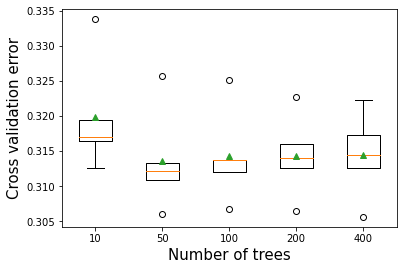

In [31]:
#Tuning only the number of trees in the model
def get_models():
    models = dict()
    # define number of trees to consider
    n_trees = [10, 50, 100, 200, 400]
    for n in n_trees:
        models[str(n)] = AdaBoostClassifier(n_estimators=n,random_state=1)
    return models

# evaluate a given model using cross-validation
def evaluate_model(model, X_train, y_train):
    # define the evaluation procedure
    cv = KFold(n_splits=5, shuffle=True, random_state=1)
    # evaluate the model and collect the results
    scores = np.sqrt(-cross_val_score(model, X_train, y_train, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1))
    return scores

# get the models to evaluate
models = get_models()
# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
    # evaluate the model
    scores = evaluate_model(model, X_train, y_train)
    # store the results
    results.append(scores)
    names.append(name)
    # summarize the performance along the way
    print('>%s %.3f (%.3f)' % (name, np.mean(scores), np.std(scores)))
# plot model performance for comparison
plt.boxplot(results, labels=names, showmeans=True)
plt.ylabel('Cross validation error',fontsize=15)
plt.xlabel('Number of trees',fontsize=15)

>3 0.313 (0.009)
>5 0.322 (0.009)
>10 0.345 (0.010)
>20 0.333 (0.009)


Text(0.5, 0, 'Depth of each tree')

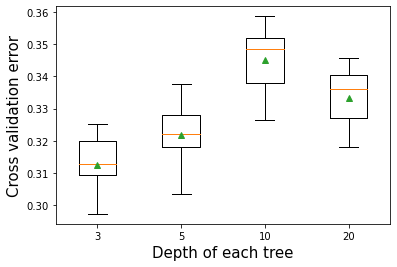

In [15]:
# Tuning only the depth of the model
def get_models():
    models = dict()
    n_depth = [3, 5, 10, 20]
    for n in n_depth:
        # define base model
        base = DecisionTreeClassifier(max_depth=n)
        # define ensemble model
        models[str(n)] = AdaBoostClassifier(base_estimator=base,n_estimators=50)
    return models

# evaluate a given model using cross-validation
def evaluate_model(model, X_train, y_train):
    # define the evaluation procedure
    cv = KFold(n_splits=10, shuffle=True, random_state=1)
    # evaluate the model and collect the results
    scores = np.sqrt(-cross_val_score(model, X_train, y_train, scoring='precision', cv=cv, n_jobs=-1))
    return scores

# get the models to evaluate
models = get_models()
# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
    # evaluate the model
    scores = evaluate_model(model, X_train, y_train)
    # store the results
    results.append(scores)
    names.append(name)
    # summarize the performance along the way
    print('>%s %.3f (%.3f)' % (name, np.mean(scores), np.std(scores)))
plt.boxplot(results, labels=names, showmeans=True)
plt.ylabel('Cross validation error',fontsize=15)
plt.xlabel('Depth of each tree',fontsize=15)

>0.0001 0.3 (0.0)
>0.001 0.3 (0.0)
>0.01 0.3 (0.0)
>0.1 0.3 (0.0)
>1.0 0.3 (0.0)


Text(0.5, 0, 'Learning rate')

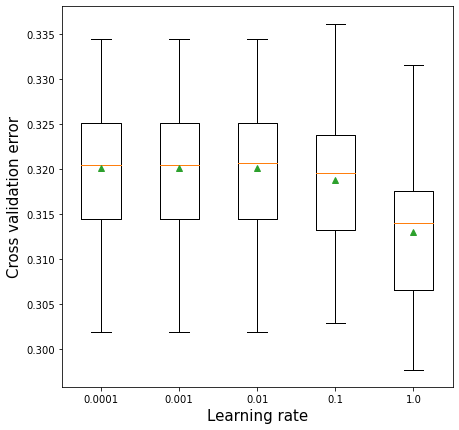

In [16]:
#Tuning only the learning rate of the model
def get_models():
    models = dict()
    # explore learning rates from 0.1 to 2 in 0.1 increments
    n_rate = [0.0001, 0.001, 0.01, 0.1, 1.0]
    for n in n_rate:
        models[n] = AdaBoostClassifier(learning_rate=n)
    return models

# evaluate a given model using cross-validation
def evaluate_model(model, X_train, y_train):
    # define the evaluation procedure
    cv = KFold(n_splits=10, shuffle=True, random_state=1)
    # evaluate the model and collect the results
    scores = np.sqrt(-cross_val_score(model, X_train, y_train, scoring='precision', cv=cv, n_jobs=-1))
    return scores

# get the models to evaluate
models = get_models()
# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
    # evaluate the model
    scores = evaluate_model(model, X_train, y_train)
    # store the results
    results.append(scores)
    names.append(name)
    # summarize the performance along the way
    print('>%s %.1f (%.1f)' % (name, np.mean(scores), np.std(scores)))
# plot model performance for comparison
plt.figure(figsize=(7, 7))
plt.boxplot(results, labels=names, showmeans=True)
plt.ylabel('Cross validation error',fontsize=15)
plt.xlabel('Learning rate',fontsize=15)

In [36]:
#More specifically tuning the hyperparameters of the model
model = AdaBoostClassifier(random_state=1)
grid = dict()
grid['n_estimators'] = [25, 50, 100]
grid['learning_rate'] = [0.001, 0.01, 0.1]
grid['base_estimator'] = [DecisionTreeClassifier(max_depth=3), DecisionTreeClassifier(max_depth=5), 
                          DecisionTreeClassifier(max_depth=7), DecisionTreeClassifier(max_depth=9)]

# define the evaluation procedure
cv = KFold(n_splits=5, shuffle=True, random_state=1)

# define the grid search procedure
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='precision')

# execute the grid search
grid_result = grid_search.fit(X_train, y_train)

# summarize the best score and configuration
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

# summarize all scores that were evaluated
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']

Best: 0.815804 using {'base_estimator': DecisionTreeClassifier(max_depth=3), 'learning_rate': 0.001, 'n_estimators': 25}


In [37]:
#Model with most optimal hyperparameters
model = AdaBoostClassifier(DecisionTreeClassifier(max_depth=3), random_state=1,n_estimators=25,learning_rate = 0.001).fit(X_train,y_train)


Accuracy:  86.43024946862064
ROC-AUC:  0.8653991371297325
Precision:  0.9430431244914564
Recall:  0.19508500252482747


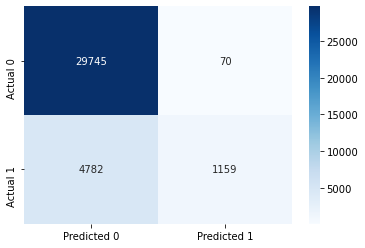

In [49]:
#The confusion matrix for the desired threshold for X_train
desired_threshold = 0.83

y_pred_prob = model.predict_proba(X_train)[:,1] 

y_pred = y_pred_prob > desired_threshold
y_pred = y_pred.astype(int)

print("Accuracy: ",accuracy_score(y_pred, y_train)*100)  

fpr, tpr, auc_thresholds = roc_curve(y_train, y_pred_prob)
print("ROC-AUC: ",auc(fpr, tpr))# AUC of ROC

print("Precision: ", precision_score(y_train, y_pred))
print("Recall: ", recall_score(y_train, y_pred))

cm = pd.DataFrame(confusion_matrix(y_train, y_pred), 
                  columns=['Predicted 0', 'Predicted 1'], index = ['Actual 0', 'Actual 1'])
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g');

Accuracy:  86.7897091722595
ROC-AUC:  0.8736013626321115
Precision:  0.9292604501607717
Recall:  0.19958563535911603


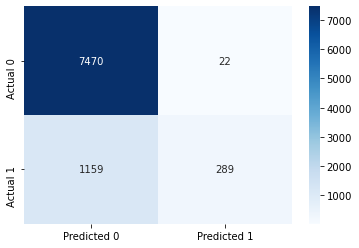

In [50]:
#The confusion matrix for the desired threshold for X_test
desired_threshold = 0.83

y_pred_prob = model.predict_proba(X_test)[:,1] 

y_pred = y_pred_prob > desired_threshold
y_pred = y_pred.astype(int)

print("Accuracy: ",accuracy_score(y_pred, y_test)*100)  

fpr, tpr, auc_thresholds = roc_curve(y_test, y_pred_prob)
print("ROC-AUC: ",auc(fpr, tpr))# AUC of ROC

print("Precision: ", precision_score(y_test, y_pred))
print("Recall: ", recall_score(y_test, y_pred))

cm = pd.DataFrame(confusion_matrix(y_test, y_pred), 
                  columns=['Predicted 0', 'Predicted 1'], index = ['Actual 0', 'Actual 1'])
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g');

Accuracy:  87.90827740492169
ROC-AUC:  0.8736013626321115
Precision:  0.603613777526821
Recall:  0.7382596685082873


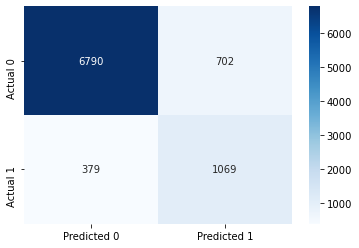

In [41]:
desired_threshold = 0.83

y_pred_prob = model.predict_proba(X_test)[:,1] 

y_pred = y_pred_prob > desired_threshold
y_pred = y_pred.astype(int)

print("Accuracy: ",accuracy_score(y_pred, y_test)*100)  

fpr, tpr, auc_thresholds = roc_curve(y_test, y_pred_prob)
print("ROC-AUC: ",auc(fpr, tpr))# AUC of ROC

print("Precision: ", precision_score(y_test, y_pred))
print("Recall: ", recall_score(y_test, y_pred))

cm = pd.DataFrame(confusion_matrix(y_test, y_pred), 
                  columns=['Predicted 0', 'Predicted 1'], index = ['Actual 0', 'Actual 1'])
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g');

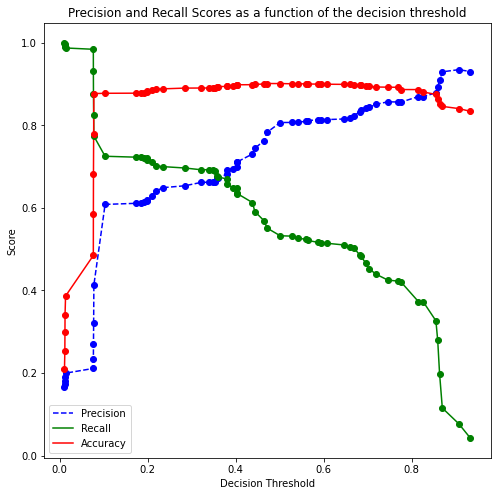

In [42]:
#Finding the optimal decision threshold
cross_val_ypred = cross_val_predict(model, X_train, y_train, cv = 5, method = 'predict_proba')

p, r, thresholds = precision_recall_curve(y_train, cross_val_ypred[:,1])
acc = np.ndarray(shape = (len(thresholds),))
i = 0
for th in thresholds:
    y_pred = cross_val_ypred[:,1] > th
    y_pred = y_pred.astype(int)
    acc[i] = accuracy_score(y_pred, y_train)
    i = i + 1
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.figure(figsize=(8, 8))
    plt.title("Precision and Recall Scores as a function of the decision threshold")
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.plot(thresholds, acc, "r-", label="Accuracy")
    plt.plot(thresholds, precisions[:-1], "o", color = 'blue')
    plt.plot(thresholds, recalls[:-1], "o", color = 'green')
    plt.plot(thresholds, acc, "o", color = 'red')
    plt.ylabel("Score")
    plt.xlabel("Decision Threshold")
    plt.legend(loc='best')
    plt.legend()
plot_precision_recall_vs_threshold(p, r, thresholds)